# Lecture 4: The Short-time Fourier Transform
Signal Processing for Interactive Systems

Cumhur Erkut (cer@create.aau.dk)

Aalborg University Copenhagen.

Last edited: 2026-02-20

## Windowing


In [ ]:
try:
  import google.colab
  IN_COLAB = True
  !mkdir -p data
  !wget https://raw.githubusercontent.com/SMC-AAU-CPH/med4-ap-jupyter/main/lecture7_Fourer_Transfom/data/trumpet.wav -P data
  !wget https://raw.githubusercontent.com/SMC-AAU-CPH/med4-ap-jupyter/main/lecture7_Fourer_Transfom/data/trumpetFull.wav -P data
except:
  IN_COLAB = False


# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wave
import IPython.display as ipd
import librosa

# If needed you can load the trumpet full audio file, and crop the beginning for a single note as trumpet.wav
# audio_data, sampling_rate = librosa.load(librosa.ex('trumpet'))

In [ ]:
# load a trumpet signal
samplingFreq, cleanTrumpetSignal = wave.read('data/trumpet.wav')
cleanTrumpetSignal = cleanTrumpetSignal/2**15 # normalise
ipd.Audio(cleanTrumpetSignal, rate=samplingFreq)

Note that there are three practical problems with the DTFT
1. we will **never** observe a signal $x_n$ from $-\infty$ to $\infty$
2. the digital frequency $\omega$ is a **continuous** parameter so we cannot store $X(\omega)$ on a computer
3. the frequency content of most signals **change as a function of time**

We solve these problems using
1. **windows** to turn infinite signals into a **finite** number of non-zero samples (this block)
2. sample the DTFT on a uniform grid of frequencies (this is called the **discrete Fourier transform** (DFT)) (next block)
3. slide a **window** across a long signal to compute a **short-time Fourier transform** (STFT) (last block)

### The rectangular window
Let us first look at the rectangular window

$$
    w_n = \begin{cases}
        1 & n=0,1,\ldots, N-1\\
        0 & \text{otherwise}
    \end{cases}\ .
$$

<div align="center">
  <img src="https://github.com/SMC-AAU-CPH/med4-ap-jupyter/blob/main/lecture7_Fourer_Transfom/figures/ap7RectWindowSketch.png?raw=1" alt="Sketch of rectangular window" width="80%">
</div>


We can think of the rectangular window $w_n$ as a way of **extracting the samples we see** from an infinitely long signal $x_n$, i.e.,

$$
    w_nx_n \quad\text{for } n=-\infty,\ldots,\infty\ .
$$

<div align="center">
  <img src="https://github.com/SMC-AAU-CPH/med4-ap-jupyter/blob/main/lecture7_Fourer_Transfom/figures/ap7WindowSignalSketch.png?raw=1" alt="Sketch of windowed signal" width="80%">
</div>


#### Example: DTFT of a window phasor
Let us look at the phasor

$
    x_n = \mathrm{e}^{j\omega_0 n}
$

which we observe for $n=0,1,\ldots,N-1$.

The DTFT of this windowed phasor is (note that subscript $N$ in $X_N(\omega)$ indicates the window length)
\begin{align}
    X_N(\omega) &= \sum_{n=-\infty}^\infty (w_nx_n) \mathrm{e}^{-j\omega n} = \sum_{n=-\infty}^\infty (w_n\mathrm{e}^{j\omega_0 n}) \mathrm{e}^{-j\omega n}\\
    &= \sum_{n=0}^{N-1} \mathrm{e}^{j\omega_0 n} \mathrm{e}^{-j\omega n} = \sum_{n=0}^{N-1}\mathrm{e}^{-j(\omega-\omega_0) n}\\
    &= \frac{1-\mathrm{e}^{-j(\omega-\omega_0)N}}{1-\mathrm{e}^{-j(\omega-\omega_0)}}
\end{align}
where the last equality follows from the **geometric series**.

In [ ]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def computeDtftShiftedRectWindow(windowLength, freqShift):
    '''Compute the DTFT of a modulated rectangular window'''
    nFreqs = 100*windowLength
    freqGrid = 2*np.pi*np.arange(nFreqs)/nFreqs-np.pi
    complexNumber = np.exp(1j*(freqGrid-freqShift))
    numerator = 1-complexNumber**windowLength
    denominator = 1-complexNumber
    dtftShiftedRectWindow = np.zeros(nFreqs,dtype=complex)
    for ii in np.arange(nFreqs):
        if denominator[ii] == 0:
            # Using L'Hospital's rule, it can be shown that the DTFT is N when the dominator is 0
            dtftShiftedRectWindow[ii] = windowLength
        else:
            dtftShiftedRectWindow[ii] = numerator[ii]/denominator[ii]
    return dtftShiftedRectWindow, freqGrid

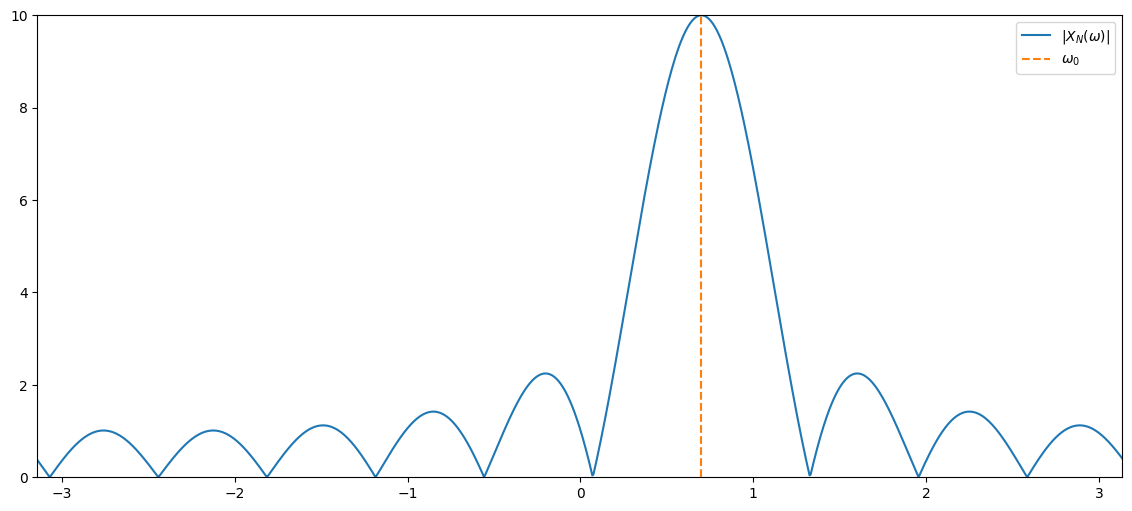

In [ ]:
windowLength = 10
signalFreq = 0.7 # rad/sample
windowedDtft, freqGrid = computeDtftShiftedRectWindow(windowLength, signalFreq)

plt.figure(figsize=(14,6))
plt.plot(freqGrid,np.abs(windowedDtft), label='$|X_N(\omega)|$')
plt.plot(np.array([signalFreq,signalFreq]),np.array([0,windowLength]), '--', label='$\omega_0$')
plt.xlim((freqGrid[0], freqGrid[-1])), plt.ylim((0,windowLength)), plt.legend();

The windowed DTFT was
$$
    X_N(\omega) = \frac{1-\mathrm{e}^{-j(\omega-\omega_0)N}}{1-\mathrm{e}^{-j(\omega-\omega_0)}}\ .
$$

Note that
1. if we set $w_0 = 0$, then $x_n=1$ and we obtain the DTFT of only the window, i.e.,
$$
    W_N(\omega) = \frac{1-\mathrm{e}^{-j\omega N}}{1-\mathrm{e}^{-j\omega}}
$$

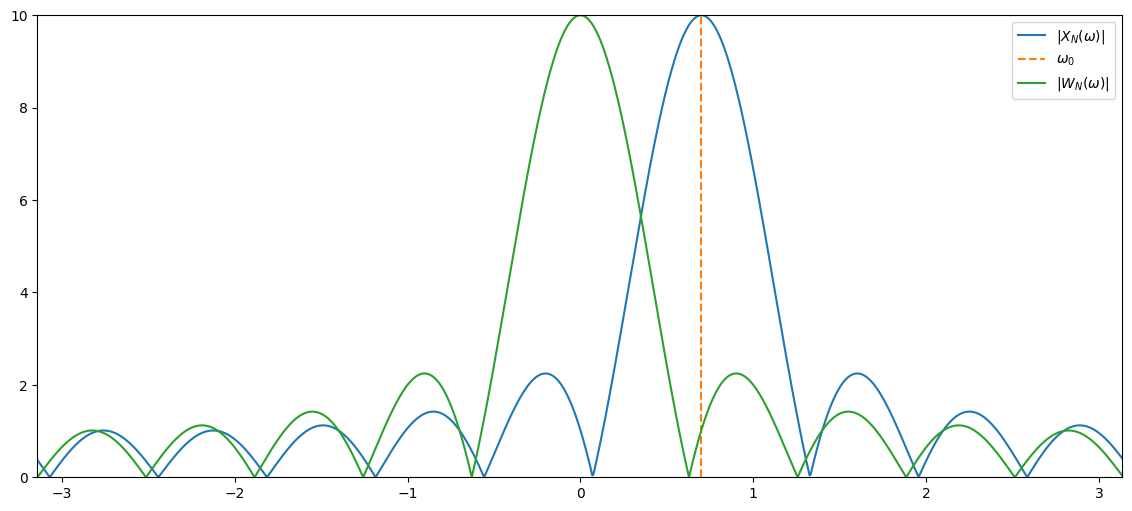

In [ ]:
rectWindowDtft,_ = computeDtftShiftedRectWindow(windowLength, 0)

plt.figure(figsize=(14,6))
plt.plot(freqGrid,np.abs(windowedDtft), label='$|X_N(\omega)|$')
plt.plot(np.array([signalFreq,signalFreq]),np.array([0,windowLength]), '--', label='$\omega_0$')
plt.plot(freqGrid,np.abs(rectWindowDtft), label='$|W_N(\omega)|$')
plt.xlim((freqGrid[0], freqGrid[-1])), plt.ylim((0,windowLength)), plt.legend();

2. the DTFT $X_N(\omega)$ of the windowed phasor is simply a frequency shifted version of $W(\omega)$, i.e.,
$$
    X_N(\omega) = W_N(\omega-\omega_0)\ .
$$
This is also called the **modulation property** of the DTFT.

3. if we let $N\to\infty$, it can be shown that
$$
    \lim_{N\to\infty}X_N(\omega) =X(\omega) =  \begin{cases}
        \infty & \omega = \omega_0\\
        0 & \text{otherwise}
    \end{cases}\ .
$$
Thus, the DTFT $X(\omega)$ of a phasor of infinite duration has an infinite peak at $\omega_0$ and is zero otherwise.

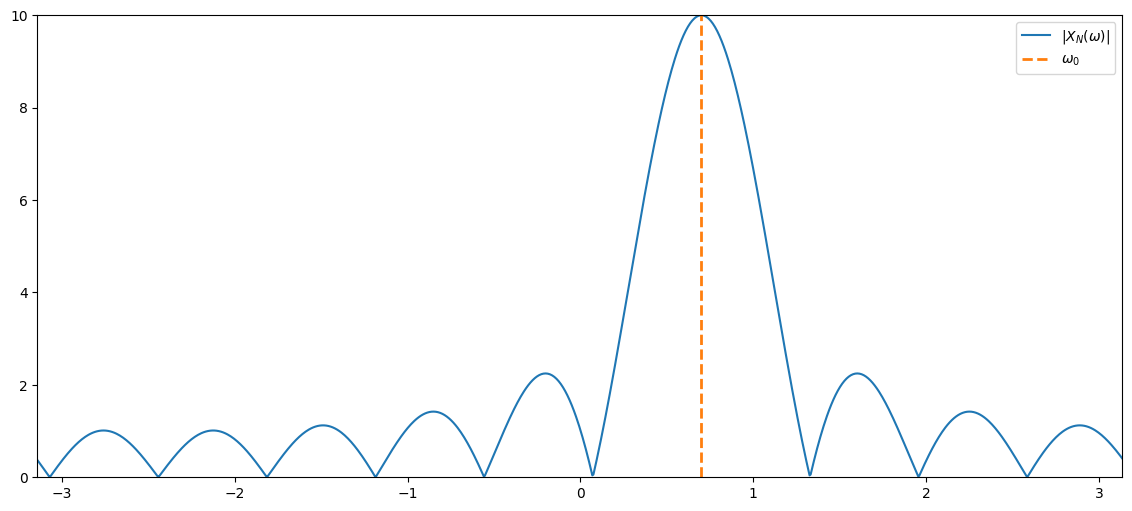

In [ ]:
windowLength = 10
windowedDtftN, freqGridN = computeDtftShiftedRectWindow(windowLength, signalFreq)

plt.figure(figsize=(14,6))
plt.plot(freqGridN,np.abs(windowedDtftN), label='$|X_N(\omega)|$')
plt.plot(np.array([signalFreq,signalFreq]),np.array([0,windowLength]), '--', linewidth=2, label='$\omega_0$')
plt.xlim((freqGridN[0], freqGridN[-1])), plt.ylim((0,windowLength)), plt.legend();

### Windowing and its influence of the DTFT
Assume that we observe $N$ samples of a signal $x_n$ with DTFT $X(\omega)$. How is the DTFT $X_N(\omega)$ of the windowed signal related to $X(\omega)$? We know that the windowed DTFT and the inverse DTFT are given by
\begin{align}
    X_N(\omega) &= \sum_{n=-\infty}^\infty w_nx_n\mathrm{e}^{-j\omega n} = \sum_{n=0}^{N-1} x_n\mathrm{e}^{-j\omega n}\\
    x_n &= \frac{1}{2\pi}\int_{-\pi}^\pi X(\tilde{\omega})\mathrm{e}^{j\tilde{\omega} n}d\tilde{\omega}
\end{align}
where we have added a $\tilde{\cdot}$ on top of $\omega$ in the last equation to indicate that it is an integration variable.

Inserting the last equation into the first results in
$$
    X_N(\omega) = \frac{1}{2\pi}\int_{-\pi}^\pi X(\tilde{\omega})\left[\sum_{n=0}^{N-1} \mathrm{e}^{j\tilde{\omega} n}\mathrm{e}^{-j\omega n}\right]d\tilde{\omega} =  \frac{1}{2\pi}\int_{-\pi}^\pi X(\tilde{\omega})W(\omega-\tilde{\omega})d\tilde{\omega}
$$
which is a **convolution** between $X(\omega)$ and the DTFT $W(\omega)$ of the rectangular window.

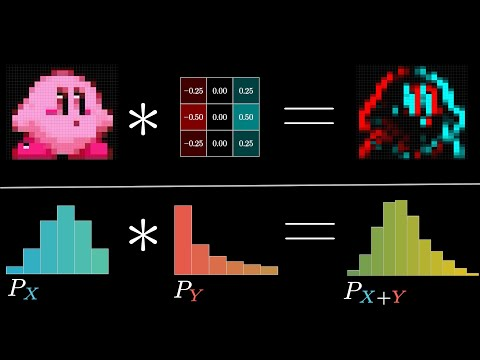

In [ ]:
video = ipd.YouTubeVideo('KuXjwB4LzSA')  # If you need a refresher, here is GREAT CONVOLUTION VIDE FROM 3BLUE1BROWN
# Display the video
display(video)


Note that applying a window is equivalent to **low-pass filtering** the DTFT $X(\omega)$. This causes frequency **smearing**!

<div align="center">
  <img src="https://github.com/SMC-AAU-CPH/med4-ap-jupyter/blob/main/lecture7_Fourer_Transfom/figures/ap7WindowSmearing.png?raw=1" alt="Frequency smearing of windows" width="80%">
</div>


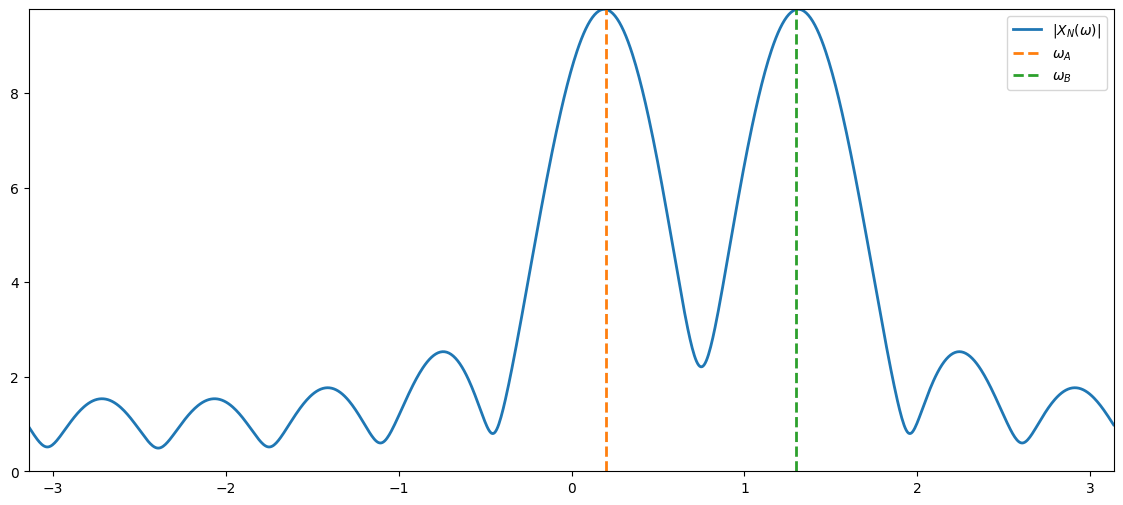

In [ ]:
windowLength = 10
signalFreqA = 0.2 # rad/sample
signalFreqB = 1.3 # rad/sample
windowedDtftA, freqGrid = computeDtftShiftedRectWindow(windowLength, signalFreqA)
windowedDtftB, _ = computeDtftShiftedRectWindow(windowLength, signalFreqB)
windowedDtft = windowedDtftA+windowedDtftB

plt.figure(figsize=(14,6))
plt.plot(freqGrid,np.abs(windowedDtft), linewidth=2, label='$|X_N(\omega)|$')
plt.plot(np.array([signalFreqA,signalFreqA]),np.array([0,np.max(np.abs(windowedDtft))]), '--', linewidth=2, label='$\omega_A$')
plt.plot(np.array([signalFreqB,signalFreqB]),np.array([0,np.max(np.abs(windowedDtft))]), '--', linewidth=2, label='$\omega_B$')
plt.xlim((freqGridN[0], freqGridN[-1])), plt.ylim((0,np.max(np.abs(windowedDtft)))), plt.legend();

### Bandwidth and sidelobes of windows
Ideally, we would like a window with
- **narrow bandwidth** to minimise frequency smearing
- **high sidelobe attenuation** to minimise spectal leakage

Unfortunately, decreasing the bandwidth increases the sidelobes and vice versa for a fixed $N$.
<div align="center">
  <img src="https://github.com/SMC-AAU-CPH/med4-ap-jupyter/blob/main/lecture7_Fourer_Transfom/figures/ap7WindowProperties.png?raw=1" alt="Window properties" width="80%">
</div>


As no perfect window exists, many windows have been suggested. Note that
- the windows have different trade-offs between bandwidth and sidelobe attenuation
- examples of popular windows are **rectangular**, **sine**, **Hamming**, **Hanning**, **Kaiser**, and **Gaussian**. As an example, the hanning window is given by
$$
    w_n = \begin{cases}
        0.5-0.5\cos(2\pi n/(N-1)) & n = 0, 1, \ldots, N-1\\
        0 & \text{otherwise}\ .
    \end{cases}
$$
- the rectangular window has the smallest bandwidth and the lowest sidelobe attenuation
- increasing the window length $N$ decreases the bandwidth and increases the sidelobe attenuation.

In [ ]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

windowLength = 10
samplingIndices = np.arange(windowLength)
rectWindow = np.ones(windowLength)
hanningWindow = np.hanning(windowLength)
hammingWindow = np.hamming(windowLength)

nDft = 1000
freqGrid = 2*np.pi*np.arange(nDft)/nDft-np.pi
dtftRectWindow = np.fft.fftshift(np.fft.fft(rectWindow,nDft))
dtftHanningWindow = np.fft.fftshift(np.fft.fft(hanningWindow,nDft))
dtftHammingWindow = np.fft.fftshift(np.fft.fft(hammingWindow,nDft))

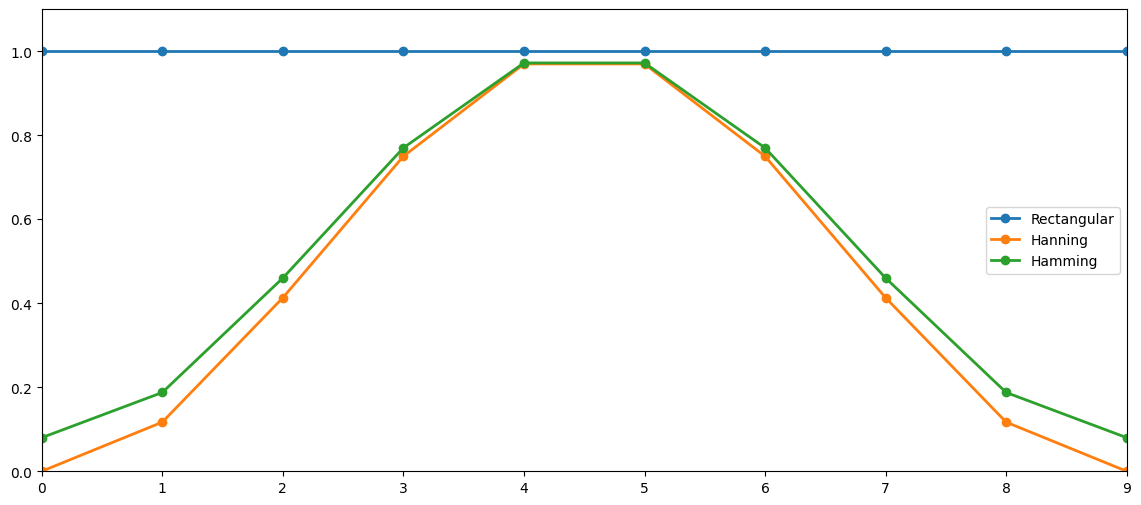

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(samplingIndices,rectWindow,'o-',linewidth=2, label='Rectangular')
plt.plot(samplingIndices,hanningWindow,'o-', linewidth=2, label='Hanning')
plt.plot(samplingIndices,hammingWindow,'o-', linewidth=2, label='Hamming')
plt.xlim((samplingIndices[0],samplingIndices[-1])), plt.ylim((0,1.1)), plt.legend();

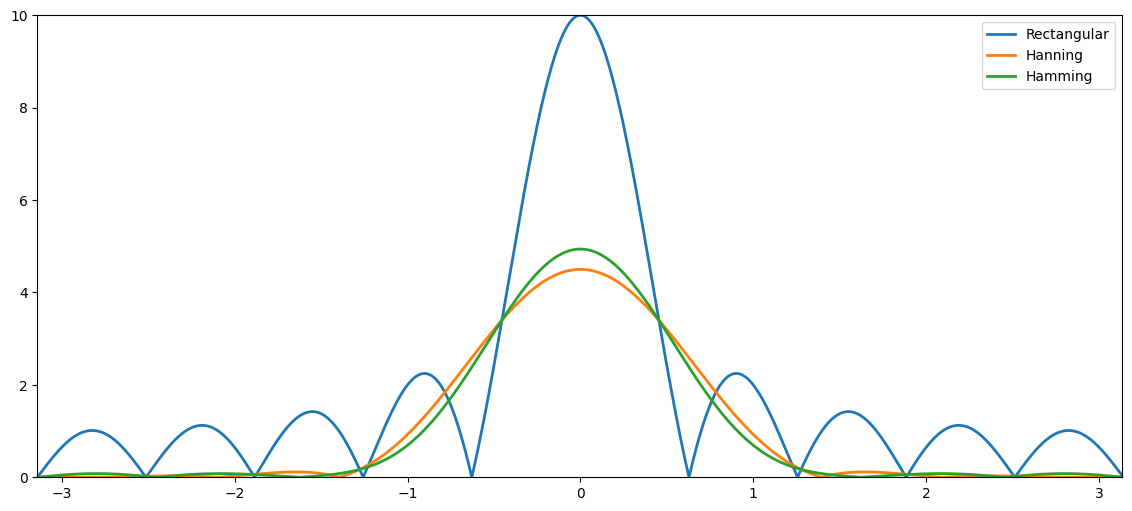

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(freqGrid,np.abs(dtftRectWindow), linewidth=2, label='Rectangular')
plt.plot(freqGrid,np.abs(dtftHanningWindow), linewidth=2, label='Hanning')
plt.plot(freqGrid,np.abs(dtftHammingWindow), linewidth=2, label='Hamming')
plt.xlim((freqGrid[0],freqGrid[-1])), plt.ylim((0,windowLength)),plt.legend();

### Summary
1. A window is used to extract a portion of a signal.
2. If we extract the $N$ samples $n=0,1,\ldots,N-1$, the windowed DTFT is
$$
    X_N(\omega) = \sum_{n=-\infty}^{\infty} w_n x_n \mathrm{e}^{-j\omega n} = \sum_{n=0}^{N-1} w_n x_n \mathrm{e}^{-j\omega n}
$$
3. Windowing a signal introduces frequency **smearing** and **leakage**, and these decrease as the window length increases
4. Many differenct windows exist and they trade-off the bandwidth for the sidelobe attenuation in different ways.

## The discrete Fourier transform
In the next 20 minutes, you will learn
- how the DFT is defined
- how the DFT is related to the DTFT
- how it is computed using Fast Fourier Transform (FFT)

### The discrete Fourier transform
The **discrete Fourier transform** (DFT) is a sampled version of the windowed DTFT, i.e.,
$$
    X_N(\omega_f) = \sum_{n=0}^{N-1} x_n \mathrm{e}^{-j\omega_f n}
$$
where the digital frequencies are evaluated on a $F$-point grid given by
$$
    \omega_f = 2\pi f/F\qquad\text{for }f=0,1,\ldots,F-1
$$
with $F\geq N$.

---

Note that we have here assumed a rectangular window, but other windows can be used as well.

Often, the expression for $\omega_f$ is inserted directly into the DFT definition and we obtain
$$
    X_N(\omega_f) = \sum_{n=0}^{N-1} x_n \mathrm{e}^{-j2\pi n f/F}\ .
$$

In [ ]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

windowLength = 10
signalFreq = 0.3 # radians/sample
signal = np.cos(signalFreq*np.arange(windowLength))
nFreqsDtft = 2500
freqGridDtft = 2*np.pi*np.arange(nFreqsDtft)/nFreqsDtft-np.pi
windowedDtftSignal = np.fft.fftshift(np.fft.fft(signal,nFreqsDtft))
nFreqsDft = 26
freqGridDft = 2*np.pi*np.arange(nFreqsDft)/nFreqsDft-np.pi
dftSignal = np.fft.fftshift(np.fft.fft(signal,nFreqsDft))

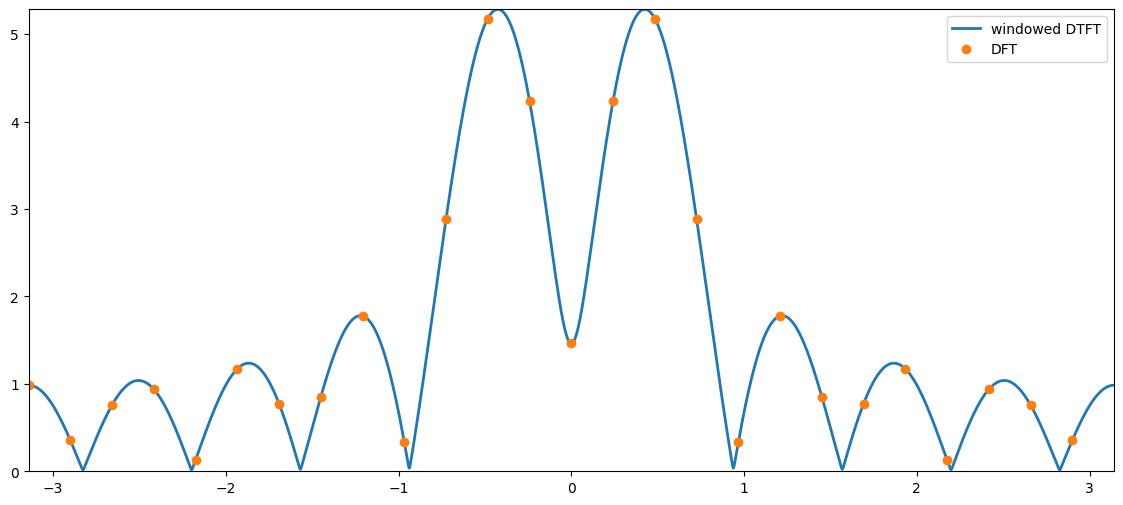

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(freqGridDtft,np.abs(windowedDtftSignal), linewidth=2, label='windowed DTFT');
plt.plot(freqGridDft,np.abs(dftSignal), 'o', linewidth=2, label='DFT')
plt.xlim((freqGridDtft[0],freqGridDtft[-1])), plt.ylim((0,np.max(np.abs(windowedDtftSignal)))),plt.legend();

#### The inverse DFT
Recall that the inverse DTFT is given by
$$
    x_n = \frac{1}{2\pi}\int_{-\pi}^{\pi} X(\omega) \mathrm{e}^{j\omega n}d\omega\ .
$$

The **inverse DFT** is given by
$$
    x_n = \frac{1}{F}\sum_{f=0}^{F-1} X(\omega_f) \mathrm{e}^{j\omega_f n}
$$
where $\omega_f=2\pi f/F$.

#### The fast Fourier transform
The **fast Fourier transform** (FFT) computes the DFT, but is a computationally efficient way.

Note that
- computing the DFT directly from its definition costs in the order of $F^2$ floating point (flops) operations (we write this as $\mathcal{O}(F^2)$).
- computing the DFT using an FFT algorithm reduces the cost to just $\mathcal{O}(F\log_2 F)$ flops
- most FFT algorithms are working most efficiently when $\log_2(F)$ is an integer
- most FFT algorithms are slow (relatively speaking) if $F$ is prime or has large prime factors (i.e., if you factorise $F$ into a product of prime numbers and any of these are large, then most FFT algorithms will be slow)
- entire books have been written on FFT algorithms, but the most important thing to remember is that they are all just different ways of compute the DFT as fast as possible!

### The short-time Fourier transform (STFT)
In most practical signals, the frequency content changes as a function of time.

<div align="center">
  <img src="https://github.com/SMC-AAU-CPH/med4-ap-jupyter/blob/main/lecture7_Fourer_Transfom/figures/ap7SpectrogramSketch.png?raw=1" alt="Spectrogram sketch" width="70%">
</div>


Assume that we have a long signal $x_n$ and a much shorter window $w_n$ of length $N$ which is zero everywhere, except for $n=0,1,...,N-1$.

To analyse the signal, we slide it relative to the window. Mathematically, we can slide the signal by considering
$$
    x_{n+lL}
$$

for different $l$ where
- $l$ is the **frame index**
- $L$ is the **hop size**.

<div align="center">
  <img src="https://github.com/SMC-AAU-CPH/med4-ap-jupyter/blob/main/lecture7_Fourer_Transfom/figures/ap7StftFrameHop.png?raw=1" alt="Frame hop sketch" width="90%">
</div>


If we combine this with a window of length $N$, we obtain the **STFT** to
$$
    X_N(\omega_f, l) = \sum_{n=-\infty}^\infty w_n x_{n+lL} \mathrm{e}^{-j\omega_fn} = \sum_{n=0}^{N-1} (w_nx_{n+lL}) \mathrm{e}^{-j\omega_fn}
$$
which can be computed using the **DFT**.

Thus,
- the **STFT** is simply a collection of **DFTs** computed at different positions of the signal
- the samples we see through the window at a given position is called a **frame** or a **segment** and is indexed by the frame index $l$
- unlike the DFT which only depends on the frequency index $f$, the STFT also depends on the frame index $l$

#### The spectrogram
The spectrogram $S_x(\omega_f,l)$ is the **squared amplitude response** of the STFT, i.e.,
$$
    S_\text{x}(\omega_f,l) = |X_N(\omega_f, l)|^2\ .
$$

The spectrogram is used everywhere to visualise the frequency content as a function of time!

In [ ]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.io.wavfile as wave
import IPython.display as ipd

def limitDynamicRange(spectrogram, maxRangeDb):
    minVal = np.max(spectrogram)*10**(-maxRangeDb/10)
    # set all values below minVal to minVal
    spectrogram[spectrogram < minVal] = minVal
    return spectrogram

# load a trumpet signal
samplingFreq, trumpetSignal = wave.read('data/trumpetFull.wav')
trumpetSignal = trumpetSignal/2**15 # normalise
ipd.Audio(trumpetSignal, rate=samplingFreq)

In [ ]:
frameLength = int(np.round(0.05*samplingFreq)) # samples
hopSize = 0.75*frameLength # samples
nDft = 2**13
maxDynamicRange = 80 # dB
freqVector, timeVector, specgram = sig.spectrogram(trumpetSignal, \
    fs=samplingFreq, window=np.hanning(frameLength), nperseg=frameLength, noverlap=hopSize, nfft=nDft)

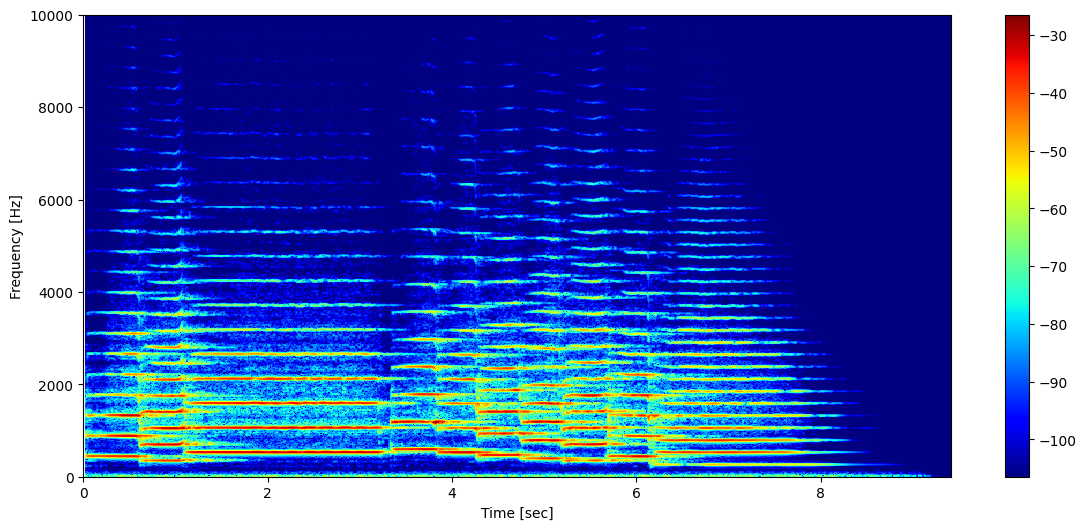

In [ ]:
plt.figure(figsize=(14,6))
plt.pcolormesh(timeVector, freqVector, 10*np.log10(limitDynamicRange(specgram, maxDynamicRange)), cmap='jet')
plt.xlabel('Time [sec]'), plt.ylabel('Frequency [Hz]')
plt.colorbar(), plt.xlim((0,timeVector[-1])), plt.ylim((0,10000));
ipd.Audio(trumpetSignal, rate=samplingFreq)

### Summary
1. The **discrete Fourier transform** (DFT) is a sampled version of the **windowed DTFT**, i.e.,
$$
    X_N(\omega_f) = \sum_{n=0}^{N-1} x_n \mathrm{e}^{-j\omega_f n}
$$
where $\omega_f = 2\pi f/F$ for $f=0,1,\ldots,F-1$ with $F\geq N$.

2. The DFT can be computed efficiently using an **FFT** algorithm.

3. The **short-time Fourier transform** (STFT) is the DFT of different frames of the signal, i.e.,
$$
    X_N(\omega_f, l) = \sum_{n=0}^{N-1} (w_nx_{n+lL}) \mathrm{e}^{-j\omega_fn}
$$
where $l$ is the **frame index** and $L$ the **hop size**.

4. The spectrogram is the **squared amplitude response** of the STFT.

#### Exercise SMC: Obtain the same STFT using librosa.

In [ ]:
# @title Solution (unhide if get stuck)
# calculate the STFT of the trumpet signal using librosa
import librosa

D = librosa.stft(trumpetSignal)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(14,6))
# Change y axis up to 10kHz
plt.ylim(0,10000)
librosa.display.specshow(S_db, sr=samplingFreq, x_axis='time', y_axis='linear',cmap='jet')
plt.colorbar()

#### Exercise MED: Obtain a time-frewquency analysis of an EEG signal

https://mne.tools/stable/auto_tutorials/intro/10_overview.html#time-frequency-analysis

In [ ]:
# @title Solution (unhide if get stuck)
# calculate the STFT of the trumpet signal using librosa
!pip install mne --quiet
import numpy as np
import mne
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)

# print(raw)
# print(raw.info)

raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw.plot(duration=5, n_channels=30)


###### Epoching continuous data and time-frequency analysis
The Raw object and the events array are the bare minimum needed to create an Epochs object, which we create with the Epochs class constructor. Here we’ll also specify some data quality constraints: we’ll reject any epoch where peak-to-peak signal amplitude is beyond reasonable limits for that channel type. This is done with a rejection dictionary; you may include or omit thresholds for any of the channel types present in your data. The values given here are reasonable for this particular dataset, but may need to be adapted for different hardware or recording conditions. For a more automated approach, consider using the autoreject package.


In [ ]:
reject_criteria = dict(
    mag=4000e-15,  # 4000 fT
    grad=4000e-13,  # 4000 fT/cm
    eeg=150e-6,  # 150 µV
    eog=250e-6,
)  # 250 µV

In [ ]:
events = mne.find_events(raw, stim_channel="STI 014")
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "smiley": 5,
    "buttonpress": 32,
}

epochs = mne.Epochs(
    raw,
    events,
    event_id=event_dict,
    tmin=-0.2,
    tmax=0.5,
    reject=reject_criteria,
    preload=True,
)


319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 319 events and 106 original time points ...
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped


In [ ]:
conds_we_care_about = ["auditory/left", "auditory/right", "visual/left", "visual/right"]
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
aud_epochs = epochs["auditory"]
vis_epochs = epochs["visual"]
del raw, epochs  # free up memory

Dropped 7 epochs: 121, 195, 258, 271, 273, 274, 275


Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


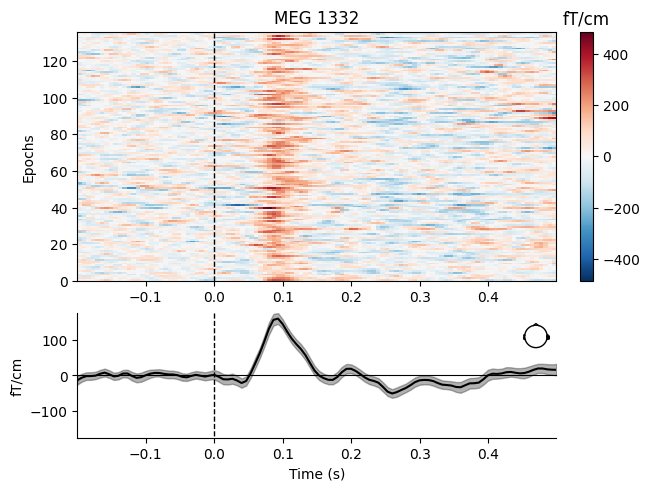

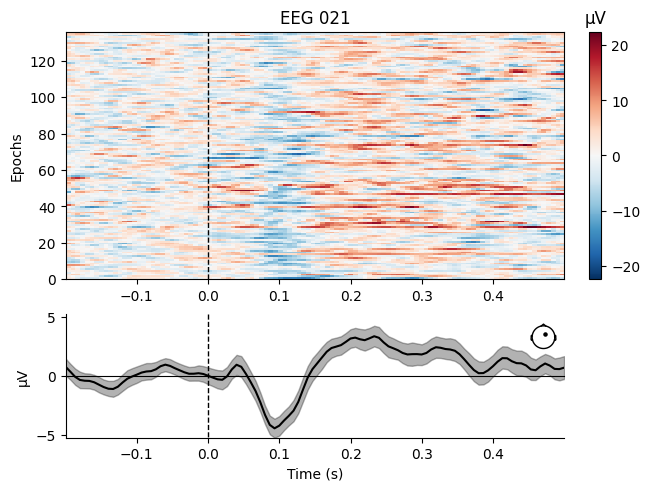

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [ ]:
aud_epochs.plot_image(picks=["MEG 1332", "EEG 021"])

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    8.8s


No baseline correction applied


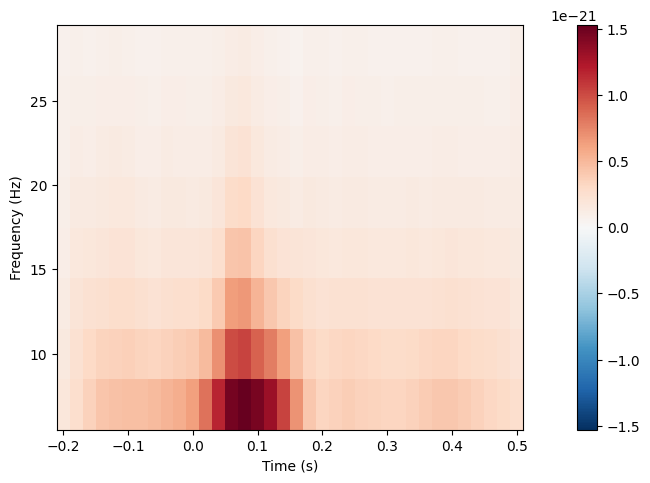

[<Figure size 640x480 with 2 Axes>]

In [ ]:
# Time-frequency
frequencies = np.arange(7, 30, 3)
power = aud_epochs.compute_tfr(
    "morlet", n_cycles=2, return_itc=False, freqs=frequencies, decim=3, average=True
)
power.plot(["MEG 1332"])